<center> <h1>TikTok Data Parsing</h1> </center>

In [1]:
# library imports
import pandas as pd
import glob, os

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 16})

## Functions

In [433]:
# functions

# get info about music track
def parse_music(s):
    music_list = s['music'][1:-1].split(', ')
    
    for item in music_list:
        if 'id' in item[:item.find(':')]:
            s['music_id'] = item[item.find('\'id\': \'')+len('\'id\': \'') : -1]
        if 'title' in item[:item.find(':')]:
            s['music_title'] = item[item.find('\'title\': \'')+len('\'title\': \'') : -1]
        if 'authorName' in item[:item.find(':')]:
            s['music_author'] = item[item.find('\'authorName\': \'')+len('\'authorName\': \'') : -1]
        if 'original' in item[:item.find(':')]:
            s['music_original'] = item[item.find('\'original\': \'')+len('\'original\': \'') : ]   
            
    return s


# extract hashtags used
def parse_hashtags(s):
    hashtag_list_of_lists = s['hashtags'][2:-2].split('}, {')
    
    reslist = []
    
    for hashtag_list in hashtag_list_of_lists:
        for item in hashtag_list.split(', '):
            if 'title' in item[:item.find(':')]:
                reslist.append(item[item.find('\'title\': \'')+len('\'title\': \'') : -1])
                
    if 'duet' in reslist:
        s['duet_used'] = True
        
    s['nr_hashtags'] = len(reslist)
    s['hashtags_used'] = ', '.join(reslist)
    
    return s


# extract tagged users
def parse_extras(s):
    extras_list_of_lists = s['extras'][2:-2].split('}, {')
    
    tagged_users = []
    reslist = []
    
    for extras_list in extras_list_of_lists:
        for item in extras_list.split(', '):
            if 'userId' in item[:item.find(':')]:
                if len(item) > 12:
                    tagged_users.append(extras_list)
    
    for tagged_user in tagged_users:
        for item in tagged_user.split(', '):
            if 'userId' in item[:item.find(':')]:
                reslist.append(item[item.find('\'userId\': \'')+len('\'userId\': \'') : -1])
    
    s['nr_tags'] = len(reslist)
    s['tagged_users'] = ', '.join(reslist)
    
    return s

# function that calls all of the other functions
def parse_table(df, hashtagname):
    df['music_id'] = ''
    df['music_title'] = ''
    df['music_author'] = ''
    df['music_original'] = ''
    df['hashtags_used'] = ''
    df['nr_hashtags'] = 0
    df['duet_used'] = False
    df['tagged_users'] = ''
    df['nr_tags'] = 0

    df = df.apply(parse_music, axis=1)
    df = df.apply(parse_hashtags, axis=1)
    df = df.apply(parse_extras, axis=1)
    
    del df['hashtags']
    del df['extras']
    del df['music']
    
    df['obtained_via'] = hashtagname
    df['rank'] = df.index
    
    return df

def parse_raw(s):
    
    # ITEM INFO
    for item in ''.join( c for c in s['itemInfos'] if  c not in '\{\}' ).split(', '):
        if '\'id\'' in item[:item.find(':')]:
            s['video_id'] = item[item.find('\'id\': \'')+len('\'id\': \'') : -1]
        if '\'text\'' in item[:item.find(':')]:
            s['video_desc'] = item[item.find('\'text\': \'')+len('\'text\': \'') : -1]
        if '\'createTime\'' in item[:item.find(':')]:
            s['video_time'] = item[item.find('\'createTime\': \'')+len('\'createTime\': \'') : -1]
        if '\'stitchEnabled\'' in item[:item.find(':')]:
            s['stitchEnabled'] = item[item.find('\'stitchEnabled\': \'')+len('\'stitchEnabled\': \'') : ]
        if '\'shareEnabled\'' in item[:item.find(':')]:
            s['shareEnabled'] = item[item.find('\'shareEnabled\': \'')+len('\'shareEnabled\': \'') : ]
        if '\'isAd\'' in item[:item.find(':')]:
            s['isAd'] = item[item.find('\'isAd\': \'')+len('\'isAd\': \'') : ]
        if '\'diggCount\'' in item[:item.find(':')]:
            s['stats_likes'] = item[item.find('\'diggCount\': \'')+len('\'diggCount\': \'') : -1]
        if '\'shareCount\'' in item[:item.find(':')]:
            s['stats_shares'] = item[item.find('\'shareCount\': \'')+len('\'shareCount\': \'') : -1]
        if '\'commentCount\'' in item[:item.find(':')]:
            s['stats_comments'] = item[item.find('\'commentCount\': \'')+len('\'commentCount\': \'') : -1]
        if '\'playCount\'' in item[:item.find(':')]:
            s['stats_plays'] = item[item.find('\'playCount\': \'')+len('\'playCount\': \'') : -1]
        if '\'duration\'' in item[:item.find(':')]:
            s['video_length'] = item[item.find('\'duration\': \'')+len('\'duration\': \'') : -1]
        if '\'isOriginal\'' in item[:item.find(':')]:
            s['isOriginal'] = item[item.find('\'isOriginal\': \'')+len('\'isOriginal\': \'') : ]
        
    # AUTHOR INFO
    for item in ''.join( c for c in s['authorInfos'] if  c not in '\{\}' ).split(', '):
        if '\'userId\'' in item[:item.find(':')]:
            s['user_id'] = item[item.find('\'userId\': \'')+len('\'userId\': \'') : -1]
        if '\'uniqueId\'' in item[:item.find(':')]:
            s['user_name'] = item[item.find('\'uniqueId\': \'')+len('\'uniqueId\': \'') : -1]
        if '\'signature\'' in item[:item.find(':')]:
            s['user_signature'] = item[item.find('\'signature\': \'')+len('\'signature\': \'') : -1]
        if '\'verified\'' in item[:item.find(':')]:
            s['user_verified'] = item[item.find('\'verified\': \'')+len('\'verified\': \'') : ]
            
    # MUSIC INFO
    for item in ''.join( c for c in s['musicInfos'] if  c not in '\{\}' ).split(', '):
        if '\'musicId\'' in item[:item.find(':')]:
            s['music_id'] = item[item.find('\'musicId\': \'')+len('\'musicId\': \'') : -1]
        if '\'musicName\'' in item[:item.find(':')]:
            s['music_title'] = item[item.find('\'musicName\': \'')+len('\'musicName\': \'') : -1]
        if '\'authorName\'' in item[:item.find(':')]:
            s['music_author'] = item[item.find('\'authorName\': \'')+len('\'authorName\': \'') : -1]
        if '\'original\'' in item[:item.find(':')]:
            s['music_original'] = item[item.find('\'original\': \'')+len('\'original\': \'') : ]
            
    # STATS INFO
    for item in ''.join( c for c in s['authorStats'] if  c not in '\{\}' ).split(', '):
        if '\'followingCount\'' in item[:item.find(':')]:
            s['authorstats_following'] = item[item.find('\'followingCount\': \'')+len('\'followingCount\': \'') : -1]
        if '\'followerCount\'' in item[:item.find(':')]:
            s['authorstats_followers'] = item[item.find('\'followerCount\': \'')+len('\'followerCount\': \'') : -1]
        if '\'heartCount\'' in item[:item.find(':')]:
            s['authorstats_heart'] = item[item.find('\'heartCount\': \'')+len('\'heartCount\': \'') : -1]
        if '\'videoCount\'' in item[:item.find(':')]:
            s['authorstats_videos'] = item[item.find('\'videoCount\': \'')+len('\'videoCount\': \'') : -1]
        if '\'diggCount\'' in item[:item.find(':')]:
            s['authorstats_diggs'] = item[item.find('\'diggCount\': \'')+len('\'diggCount\': \'') : -1]
    
    s['hashtags'] = s['textExtra']
    
    s['duet_id'] = s['duetInfo']
        
    
    return s

# extract extra information (hashtags and tags) from raw data
def parse_extras_raw(s):
    hashtag_list_of_lists = s['hashtags'][2:-2].split('}, {')
    
    reslist = []
    tagged_users = []
    
    for hashtag_list in hashtag_list_of_lists:
        for item in hashtag_list.split(', '):
            if 'HashtagName' in item[:item.find(':')]:
                if len(item[item.find('\'HashtagName\': \'')+len('\'HashtagName\': \'') : -1]) > 1:
                    reslist.append(item[item.find('\'HashtagName\': \'')+len('\'HashtagName\': \'') : -1])
                    
            if 'UserId' in item[:item.find(':')]:
                if len(item) > 12:
                    tagged_users.append(item[item.find('\'UserId\': \'')+len('\'UserId\': \'') : -1])
    
    if len(s['stickerTextList']) > 2:
        item = s['stickerTextList'][2:-2]
        s['stickerText'] = item[item.find('stickerText')+len('stickerText    ') : -1] 
    
    if 'duet' in reslist:
        s['duet_used'] = True
        
    s['nr_hashtags'] = len(reslist)
    s['hashtags_used'] = ', '.join(reslist)
    
    s['nr_tags'] = len(tagged_users)
    s['tagged_users'] = ', '.join(tagged_users)
    
    s['video_link'] = 'https://www.tiktok.com/@{}/video/{}?lang=en'.format(s['user_name'], s['video_id'])       

    return s


def parse_table_raw(df):
    
    new_cols = ['itemInfos', 'authorInfos', 'musicInfos', 'challengeInfoList', 'duetInfo', 
            'textExtra', 'authorStats', 'stickerTextList', 'video_id', 'video_desc', 
            'video_time', 'stitchEnabled', 'shareEnabled', 
            'isAd', 'stats_likes', 'stats_shares', 'stats_comments', 'stats_plays', 
            'video_length', 'isOriginal', 'user_id', 'user_name', 'user_signature', 
            'user_verified', 'music_id', 'music_title', 'music_author', 'music_original', 
            'authorstats_following', 'authorstats_followers', 'authorstats_heart', 
            'authorstats_videos', 'authorstats_diggs', 'hashtags', 'duet_id', 'extras', 
            'nr_hashtags', 'hashtags_used', 'nr_tags', 'tagged_users', 'duet_used', 'stickerText', 'video_link']                                                              


    df = df.reindex(columns=new_cols, fill_value='')

    df = df.apply(parse_raw, axis=1)
        
    df = df.apply(parse_extras_raw, axis=1)

    df['rank'] = df.index
    
    del df['itemInfos']
    del df['authorInfos']
    del df['musicInfos']
    del df['challengeInfoList']
    del df['duetInfo']
    del df['textExtra']
    del df['authorStats']
    del df['stickerTextList']
    
    return df

## Parsing files

In [3]:
# which files should I parse?
for file in os.listdir('/Users/andreasipka/Desktop/TikTok'):
    if file.endswith('_videos.csv'):        
        print(file)

blacklivesmattermovement_videos.csv
alllivesmatterwhenblacklivesmatter_videos.csv
blacklivesmatter_videos.csv
bluelivesmatter_videos.csv
all_videos.csv
blacklivesmatterally_videos.csv
alllivesmattertrump2020_videos.csv
alllivesmatternotjustblacklives_videos.csv
blm_videos.csv
georgefloyd_videos.csv
justiceforgeorgefloyd_videos.csv
babylivesmatter_videos.csv
backtheblue_videos.csv
policelivesmatter_videos.csv
breonnataylor_videos.csv
alllivesmatter_videos.csv


In [4]:
blacklivesmattermovement = pd.read_csv('blacklivesmattermovement_videos.csv')
blacklivesmattermovement = parse_table(blacklivesmattermovement, 'blacklivesmattermovement')
print('Number of blacklivesmattermovement videos: ', blacklivesmattermovement.shape[0])

Number of blacklivesmattermovement videos:  1975


In [5]:
alllivesmatterwhenblacklivesmatter = pd.read_csv('alllivesmatterwhenblacklivesmatter_videos.csv')
alllivesmatterwhenblacklivesmatter = parse_table(alllivesmatterwhenblacklivesmatter, 'alllivesmatterwhenblacklivesmatter')
print('Number of alllivesmatterwhenblacklivesmatter videos: ', alllivesmatterwhenblacklivesmatter.shape[0])

Number of alllivesmatterwhenblacklivesmatter videos:  1973


In [6]:
blacklivesmatter = pd.read_csv('blacklivesmatter_videos.csv')
blacklivesmatter = parse_table(blacklivesmatter, 'blacklivesmatter')
print('Number of blacklivesmatter videos: ', blacklivesmatter.shape[0])

Number of blacklivesmatter videos:  1956


In [7]:
blacklivesmatterally = pd.read_csv('blacklivesmatterally_videos.csv')
blacklivesmatterally = parse_table(blacklivesmatterally, 'blacklivesmatterally')
print('Number of blacklivesmatterally videos: ', blacklivesmatterally.shape[0])

Number of blacklivesmatterally videos:  197


In [8]:
alllivesmatternotjustblacklives = pd.read_csv('alllivesmatternotjustblacklives_videos.csv')
alllivesmatternotjustblacklives = parse_table(alllivesmatternotjustblacklives, 'alllivesmatternotjustblacklives')
print('Number of alllivesmatternotjustblacklives videos: ', alllivesmatternotjustblacklives.shape[0])

Number of alllivesmatternotjustblacklives videos:  755


In [9]:
blm = pd.read_csv('blm_videos.csv')
blm = parse_table(blm, 'blm')
print('Number of blm videos: ', blm.shape[0])

Number of blm videos:  1894


In [10]:
georgefloyd = pd.read_csv('georgefloyd_videos.csv')
georgefloyd = parse_table(georgefloyd, 'georgefloyd')
print('Number of georgefloyd videos: ', georgefloyd.shape[0])

Number of georgefloyd videos:  1992


In [11]:
justiceforgeorgefloyd = pd.read_csv('justiceforgeorgefloyd_videos.csv')
justiceforgeorgefloyd = parse_table(justiceforgeorgefloyd, 'justiceforgeorgefloyd')
print('Number of justiceforgeorgefloyd videos: ', justiceforgeorgefloyd.shape[0])

Number of justiceforgeorgefloyd videos:  1997


In [12]:
# probably skip this, unless looking at anti abortion stuff
bluelivesmatter = pd.read_csv('bluelivesmatter_videos.csv')
bluelivesmatter = parse_table(bluelivesmatter, 'babylivesmatter')
print('Number of bluelivesmatter videos: ', bluelivesmatter.shape[0])

Number of bluelivesmatter videos:  1745


In [13]:
breonnataylor = pd.read_csv('breonnataylor_videos.csv')
breonnataylor = parse_table(breonnataylor, 'breonnataylor')
print('Number of breonnataylor videos: ', breonnataylor.shape[0])

Number of breonnataylor videos:  1958


In [14]:
alllivesmatter = pd.read_csv('alllivesmatter_videos.csv')
alllivesmatter = parse_table(alllivesmatter, 'alllivesmatter')
print('Number of alllivesmatter videos: ', alllivesmatter.shape[0])

Number of alllivesmatter videos:  1917


In [15]:
alllivesmattertrump2020 = pd.read_csv('alllivesmattertrump2020_videos.csv')
alllivesmattertrump2020 = parse_table(alllivesmattertrump2020, 'alllivesmattertrump2020')
print('Number of alllivesmattertrump2020 videos: ', alllivesmattertrump2020.shape[0])

Number of alllivesmattertrump2020 videos:  1969


In [16]:
backtheblue = pd.read_csv('backtheblue_videos.csv')
backtheblue = parse_table(backtheblue, 'backtheblue')
print('Number of backtheblue videos: ', backtheblue.shape[0])

Number of backtheblue videos:  1810


In [17]:
policelivesmatter = pd.read_csv('policelivesmatter_videos.csv')
policelivesmatter = parse_table(policelivesmatter, 'policelivesmatter')
print('Number of policelivesmatter videos: ', policelivesmatter.shape[0])

Number of policelivesmatter videos:  1636


In [18]:
# label hashtags as pro or against to track easily

# pro BLM hashtags
blacklivesmatter['leaning'] = 'pro'
blacklivesmattermovement['leaning'] = 'pro'
alllivesmatterwhenblacklivesmatter['leaning'] = 'pro'
blacklivesmatterally['leaning'] = 'pro'
blm['leaning'] = 'pro'
georgefloyd['leaning'] = 'pro'
justiceforgeorgefloyd['leaning'] = 'pro'
breonnataylor['leaning'] = 'pro'

# against BLM hashtags
alllivesmatter['leaning'] = 'con'
alllivesmatternotjustblacklives['leaning'] = 'con'
bluelivesmatter['leaning'] = 'con'
alllivesmattertrump2020['leaning'] = 'con'
backtheblue['leaning'] = 'con'
policelivesmatter['leaning'] = 'con'

In [24]:
# Merge all the individual tables into pro and con camp

pro_videos = pd.concat([blacklivesmatter, blacklivesmattermovement, alllivesmatterwhenblacklivesmatter,
      blacklivesmatterally, blm, georgefloyd, justiceforgeorgefloyd, breonnataylor])

con_videos = pd.concat([alllivesmatter, alllivesmatternotjustblacklives, bluelivesmatter, 
                        alllivesmattertrump2020, backtheblue, policelivesmatter])

all_videos = pd.concat([merged_pro, merged_con])

### What are the numbers we are working with here?

In [25]:
print('Number of unique pro videos: ', len(pro_videos.video_id.unique()))
print('Number of unique con videos: ', len(con_videos.video_id.unique()))
print('Total unique videos: ', len(all_videos.video_id.unique()))
print('Total unique users: ', len(all_videos.user_id.unique()))
print('Total videos with duet hashtag: ', all_videos[all_videos.duet_used].shape[0])
print('Total videos with a tagged used: ', all_videos[all_videos.nr_tags > 0].shape[0])
print('My best approximation for actual number of duets: ', all_videos[(all_videos.nr_tags > 0) & 
                                                                       (all_videos.duet_used)].shape[0])

Number of unique pro videos:  12339
Number of unique con videos:  9006
Total unique videos:  21202
Total unique users:  13291
Total videos with duet hashtag:  1736
Total videos with a tagged used:  4435
My best approximation for actual number of duets:  1548


### Save to CSV

In [ ]:
# Offload to CSV

# full CSV
all_videos.to_csv('all_videos.csv')

# only duets
all_videos[(all_videos.nr_tags > 0) & (all_videos.duet_used)].to_csv('duets_only.csv')

<center> <h2>Exploring Hashtags</h2> </center>

In [149]:
# define some general hashtag categories

boosting_tags = ['fyp', 'foryou', 'foryoupage', 'viral', 'xyzbca', 'fypシ', 
                 'fy', 'foryourpage', 'trending', 'tiktok', '4u']

pro_tags = ['blacklivesmatter', 'blacklivesmattermovement', 'alllivesmatterwhenblacklivesmatter', 
            'blacklivesmatterally', 'blm', 'georgefloyd', 'justiceforgeorgefloyd', 'breonnataylor']

con_tags = ['alllivesmatter', 'alllivesmatternotjustblacklives', 'bluelivesmatter', 
            'alllivesmattertrump2020', 'backtheblue', 'policelivesmatter']

### Pro Videos

In [90]:
pro_videos_hashtags = pro_videos[['user_id', 'video_id', 'hashtags_used']]


list_to_save = []

for index, row in pro_videos_hashtags.iterrows():
    for hashtag in row['hashtags_used'].split(', '):
        list_to_save.append([row['user_id'], row['video_id'], hashtag])
        

pro_hashtag_df = pd.DataFrame(list_to_save, columns=['user_id', 'video_id', 'hashtag'])

In [94]:
pro_hashtag_df.shape[0]

(87183, 3)

### How many unique hashtags are used by pro BLM users?

In [114]:
print('Number of unique hashtags used by "pro BLM" users: ', len(pro_hashtag_df.hashtag.unique()))

Number of unique hashtags used by "pro BLM" users:  9447


### What are the most frequent hashtags connected to pro BLM hashtags?

/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0, flags=flags)


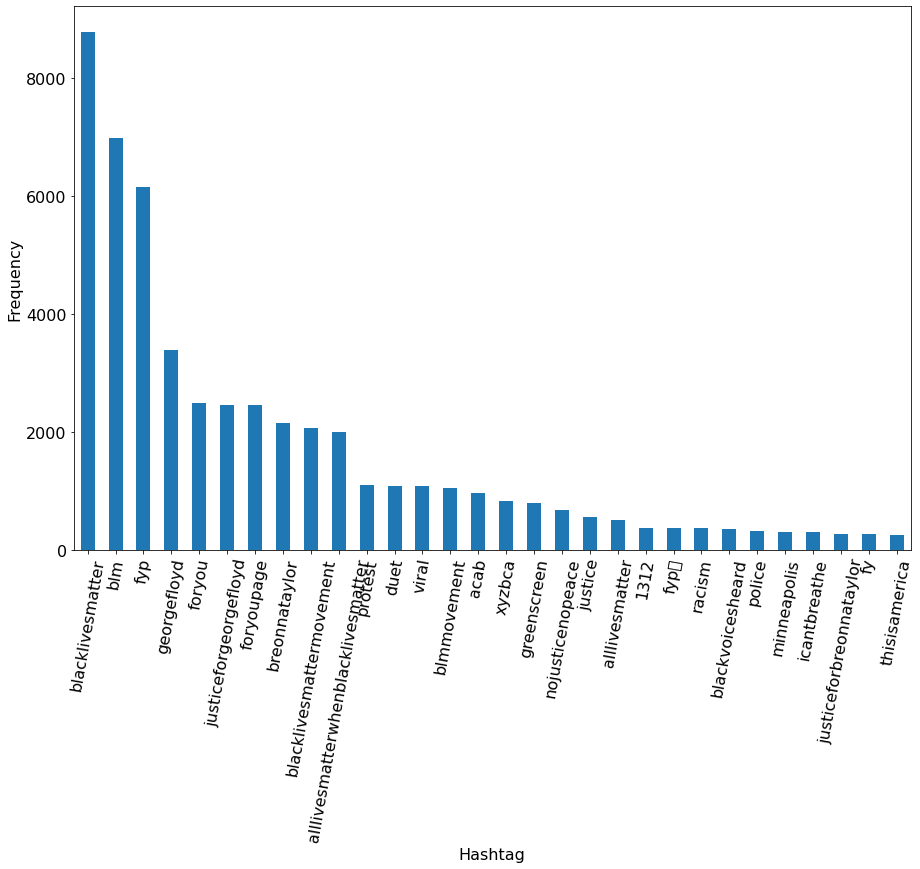

In [97]:
plt.figure(figsize=(15,10))
pro_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags related to pro BLM videos

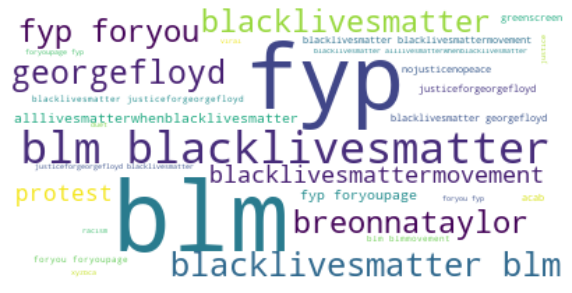

In [470]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(pro_hashtag_df['hashtag']))
wordcloud.to_file("proBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Hashtags related to pro BLM videos, with seed hashtags removed

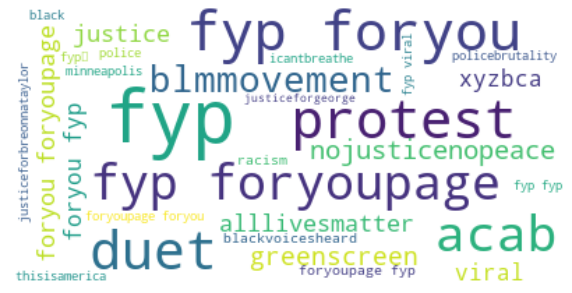

In [472]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(pro_hashtag_df[~pro_hashtag_df.hashtag.isin(pro_tags)].hashtag))
wordcloud.to_file("proBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Con Videos

In [100]:
con_videos_hashtags = con_videos[['user_id', 'video_id', 'hashtags_used']]


list_to_save = []

for index, row in con_videos_hashtags.iterrows():
    for hashtag in row['hashtags_used'].split(', '):
        list_to_save.append([row['user_id'], row['video_id'], hashtag])
        

con_hashtag_df = pd.DataFrame(list_to_save, columns=['user_id', 'video_id', 'hashtag'])

In [101]:
con_hashtag_df.shape

(67337, 3)

In [127]:
print('Number of unique hashtags used by "con BLM" users: ', len(con_hashtag_df.hashtag.unique()))

Number of unique hashtags used by "con BLM" users:  7837


### What are the most frequent hashtags connected to con BLM hashtags?


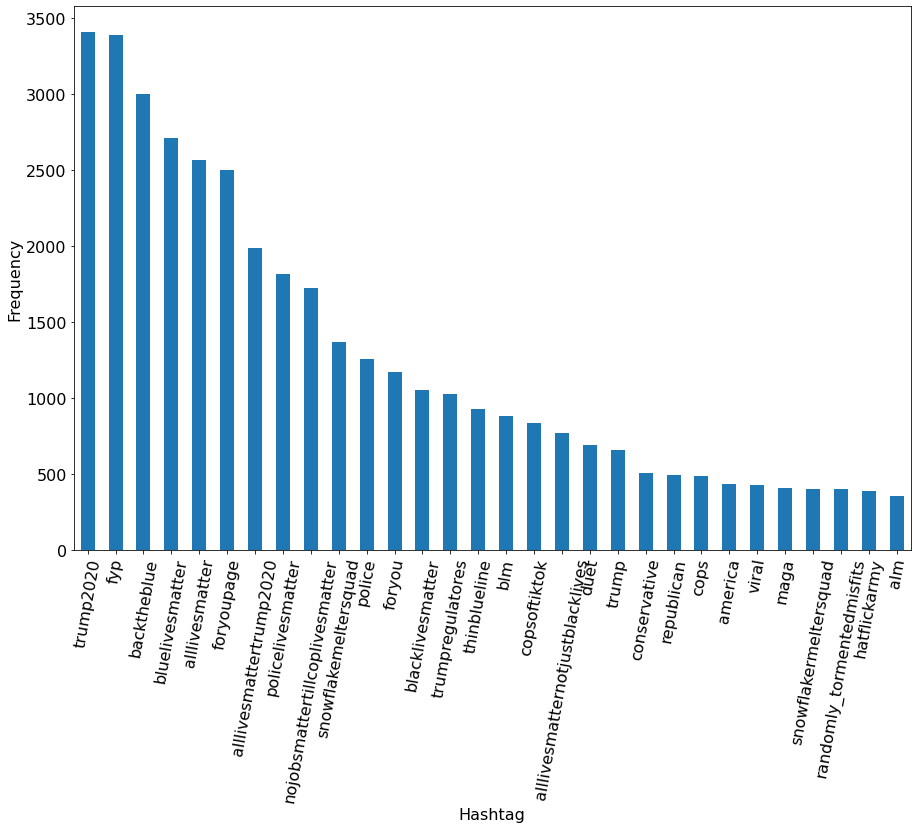

In [103]:
plt.figure(figsize=(15,10))
con_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags related to con BLM videos

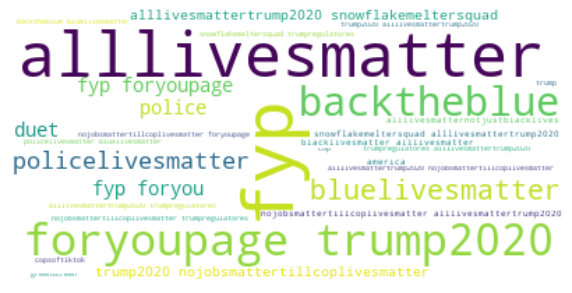

In [475]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(con_hashtag_df.hashtag))
wordcloud.to_file("conBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Hashtags related to con BLM videos, with seed hashtags removed

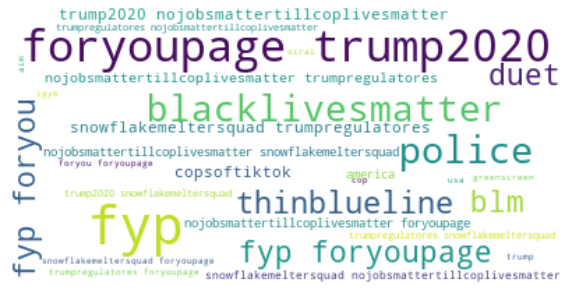

In [476]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(con_hashtag_df[~con_hashtag_df.hashtag.isin(con_tags)].hashtag))
wordcloud.to_file("conBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### all videos

In [123]:
all_videos_hashtags = all_videos[['user_id', 'video_id', 'hashtags_used']]


list_to_save = []

for index, row in all_videos_hashtags.iterrows():
    for hashtag in row['hashtags_used'].split(', '):
        list_to_save.append([row['user_id'], row['video_id'], hashtag])
        

all_hashtag_df = pd.DataFrame(list_to_save, columns=['user_id', 'video_id', 'hashtag'])

In [133]:
all_hashtag_df.shape

(154520, 3)

In [134]:
print('Number of unique hashtags in the dataset: ', len(all_hashtag_df.hashtag.unique()))

Number of unique hashtags in the dataset:  15019


### What are the most frequent hashtags in all data?

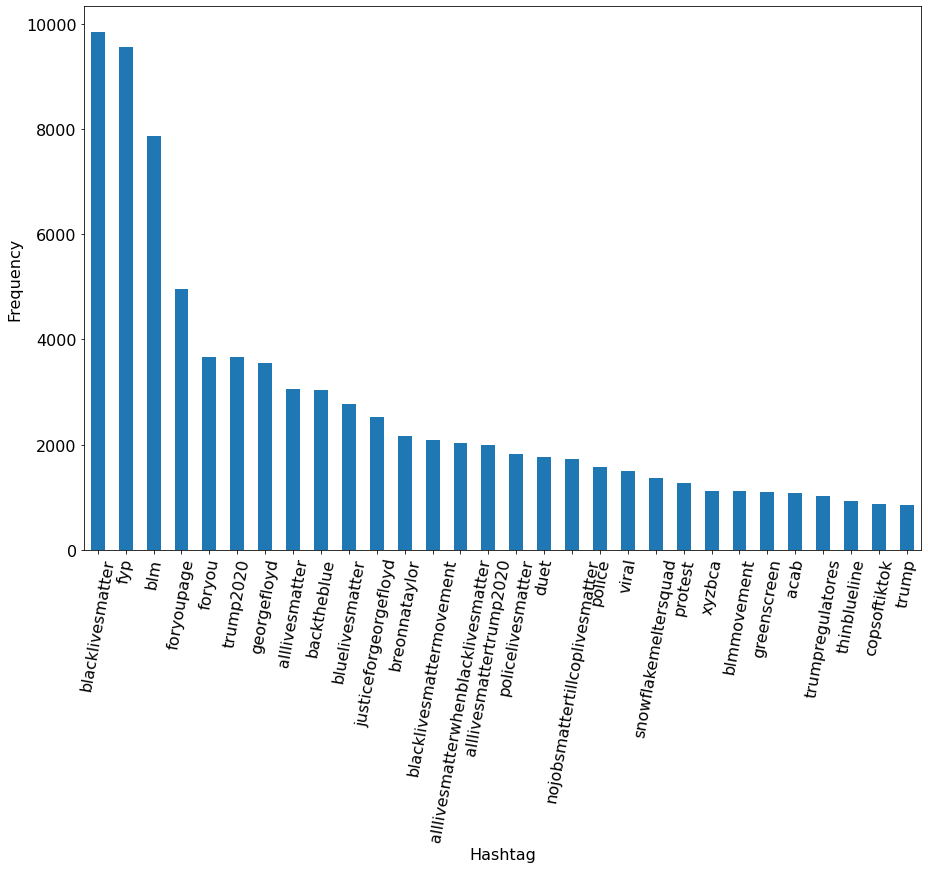

In [136]:
plt.figure(figsize=(15,10))
all_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags in the whole dataset

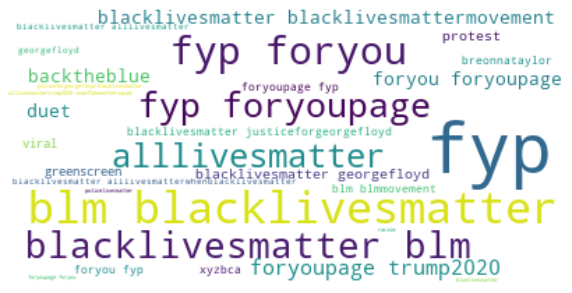

In [477]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(all_hashtag_df['hashtag']))
wordcloud.to_file("allBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [468]:
all_hashtag_df['hashtag'].value_counts().head(40)

blacklivesmatter                      9837
fyp                                   9548
blm                                   7867
foryoupage                            4951
foryou                                3667
trump2020                             3661
georgefloyd                           3556
alllivesmatter                        3065
backtheblue                           3041
bluelivesmatter                       2772
justiceforgeorgefloyd                 2518
breonnataylor                         2167
blacklivesmattermovement              2086
alllivesmatterwhenblacklivesmatter    2029
alllivesmattertrump2020               1988
policelivesmatter                     1822
duet                                  1770
nojobsmattertillcoplivesmatter        1722
police                                1573
viral                                 1506
snowflakemeltersquad                  1367
protest                               1269
xyzbca                                1128
blmmovement

### Hashtags for the whole dataset, with pro and con seeds removed

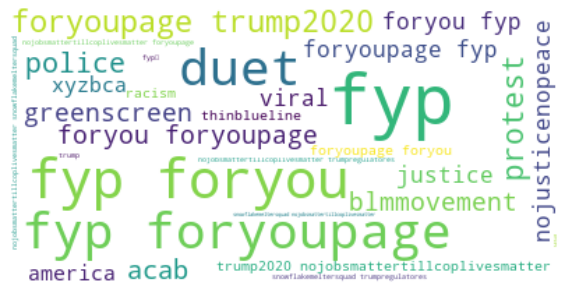

In [478]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(all_hashtag_df[~all_hashtag_df.hashtag.isin(pro_tags + con_tags)].hashtag))
wordcloud.to_file("allBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### no boosting tags or seed tags

In [484]:
pro_tags + con_tags + boosting_tags

['blacklivesmatter',
 'blacklivesmattermovement',
 'alllivesmatterwhenblacklivesmatter',
 'blacklivesmatterally',
 'blm',
 'georgefloyd',
 'justiceforgeorgefloyd',
 'breonnataylor',
 'alllivesmatter',
 'alllivesmatternotjustblacklives',
 'bluelivesmatter',
 'alllivesmattertrump2020',
 'backtheblue',
 'policelivesmatter',
 'fyp',
 'foryou',
 'foryoupage',
 'viral',
 'xyzbca',
 'fypシ',
 'fy',
 'foryourpage',
 'trending',
 'tiktok',
 '4u']

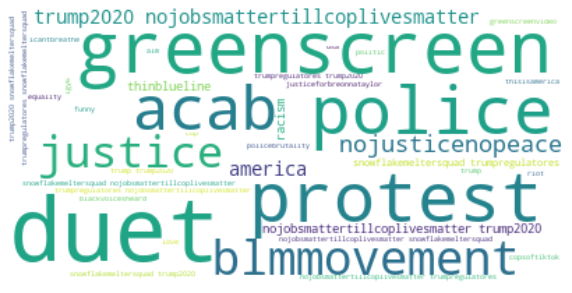

In [490]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=40, background_color="white").generate(' '.join(all_hashtag_df[~all_hashtag_df.hashtag.isin(pro_tags + con_tags + boosting_tags)].hashtag))
wordcloud.to_file("allBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [489]:
all_hashtag_df[~all_hashtag_df.hashtag.isin(pro_tags + con_tags + boosting_tags)].hashtag.value_counts().head(20)

trump2020                         3661
duet                              1770
nojobsmattertillcoplivesmatter    1722
police                            1573
snowflakemeltersquad              1367
protest                           1269
blmmovement                       1119
greenscreen                       1107
acab                              1083
trumpregulatores                  1029
thinblueline                       938
copsoftiktok                       870
trump                              861
nojusticenopeace                   697
justice                            616
cops                               596
conservative                       587
america                            571
republican                         568
racism                             474
Name: hashtag, dtype: int64

<center> <h2>Matching by sound</h2> </center>

### What are the most frequently used sounds that aren't original?

In [175]:
# TODO consider using what language original sound is classified as here as some proxy to foreign agents? 
# or maybe english as a second language speakers?

all_videos[~all_videos.music_title.isin(['original sound', 'sonido original', 'Originalton', 
                                         'Original Sound', 'оригинальный звук', 'son original',
                                         'som original', 'suono originale'])].music_title.value_counts().head(30)

Childish Gambino - This Is America / Post Malone - Congratulations    760
I NEED YOU TO                                                         404
Same Love (feat. Mary Lambert)                                        364
Mr Red White and Blue                                                 188
This Is America                                                       161
My Tears Are Becoming A Sea                                           108
Surrender                                                              85
Red Kingdom                                                            83
Officer Down                                                           72
オリジナル楽曲 - 🌏Samurai Tiktok🚀                                             57
Bad Boys (Theme From Cops)                                             56
RIP Anthony Dia                                                        48
"Go Go Go Who's Next?                                                  48
DJ Yames Mashup 6                     

### What are the most frequently used sounds in duets?

In [179]:
all_videos[(all_videos.duet_used == True) & (all_videos.nr_tags > 0)].music_title.value_counts().head(20)

original sound                                                        976
Same Love (feat. Mary Lambert)                                         93
Childish Gambino - This Is America / Post Malone - Congratulations     29
Mr Red White and Blue                                                  11
I NEED YOU TO                                                          11
Surrender                                                              10
And thats on Black Lives Matter                                        10
RIP Anthony Dia                                                         9
Magic In The Hamptons                                                   7
Original Sound                                                          7
Right Back Where We Started From                                        7
Red Kingdom                                                             7
Follow WOGASIANBRANDON                                                  6
Worship Instrumental - Instrumental   

### How many duets use original sound?

In [181]:
all_videos[(all_videos.duet_used == True) & (all_videos.nr_tags > 0) & (all_videos.music_title == 'original sound')].shape

(976, 43)

### Are there some particular original sounds that are more popular in duets?

In [182]:
all_videos[(all_videos.duet_used == True) & (all_videos.nr_tags > 0) & (all_videos.music_title == 'original sound')].music_id.value_counts()

6889175333107485446    8
6835463407244692230    6
6831679634426448645    6
6834966193955851014    6
6869460211468356358    6
                      ..
6843218524643543813    1
6855885277265791750    1
6834694850525285125    1
6811849799705316101    1
6837522210677213958    1
Name: music_id, Length: 760, dtype: int64

### Extract the top 5 ids to search on them and get more data

In [441]:
all_videos[(all_videos.duet_used == True) & (all_videos.nr_tags > 0) & (all_videos.music_title == 'original sound')].music_id.value_counts().head(5).index

Index(['6889175333107485446', '6835463407244692230', '6831679634426448645',
       '6834966193955851014', '6869460211468356358'],
      dtype='object')

<center> <h2>Parsing videos matched by sound</h2> </center>

In [465]:
# which files should I parse?
for file in os.listdir('/Users/andreasipka/Desktop/TikTok'):
    if file.endswith('_sound.csv'):        
        print(file)

6869460211468356358_sound.csv
6835463407244692230_sound.csv
6831679634426448645_sound.csv
6889175333107485446_sound.csv
6834966193955851014_sound.csv


In [449]:
sound6869460211468356358 = pd.read_csv('6869460211468356358_sound.csv')
sound6869460211468356358 = parse_table_raw(sound6869460211468356358)
print('Number of sound6869460211468356358 videos: ', sound6869460211468356358.shape[0])

Number of sound6869460211468356358 videos:  666


In [450]:
sound6835463407244692230 = pd.read_csv('6835463407244692230_sound.csv')
sound6835463407244692230 = parse_table_raw(sound6835463407244692230)
print('Number of sound6835463407244692230 videos: ', sound6835463407244692230.shape[0])

Number of sound6835463407244692230 videos:  1000


In [451]:
sound6831679634426448645 = pd.read_csv('6831679634426448645_sound.csv')
sound6831679634426448645 = parse_table_raw(sound6831679634426448645)
print('Number of sound6831679634426448645 videos: ', sound6831679634426448645.shape[0])

Number of sound6831679634426448645 videos:  469


In [452]:
sound6889175333107485446 = pd.read_csv('6889175333107485446_sound.csv')
sound6889175333107485446 = parse_table_raw(sound6889175333107485446)
print('Number of sound6889175333107485446 videos: ', sound6889175333107485446.shape[0])

Number of sound6889175333107485446 videos:  207


In [453]:
sound6834966193955851014 = pd.read_csv('6834966193955851014_sound.csv')
sound6834966193955851014 = parse_table_raw(sound6834966193955851014)
print('Number of sound6834966193955851014 videos: ', sound6834966193955851014.shape[0])

Number of sound6834966193955851014 videos:  391


In [455]:
# Merge what we have
all_sound = pd.concat([sound6869460211468356358, sound6835463407244692230, sound6831679634426448645, 
                       sound6889175333107485446, sound6834966193955851014])

### How many videos are there in the search-by-sound data?

In [463]:
all_sound.shape[0]

2733

### How many of those used #duet hashtag?

In [464]:
all_sound[all_sound.duet_used == True].shape[0]

2362